In [1]:
import random 
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
chars = sorted(set(string.ascii_lowercase))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

with open('names.txt', 'r') as f:
    names = f.read().splitlines()

random.shuffle(names)
n_train = int(0.8*len(names))
n_dev = int(0.9*len(names))
trainset = names[:n_train]
devset = names[n_train:n_dev]
testset = names[n_dev:]
len(trainset), len(devset), len(devset)

(25626, 3203, 3203)

In [3]:
def prepare_data(names, cl):
    xs, ys = [], []
    for name in names:
        name = name + '.'
        context = [stoi['.']]*cl
        for ch in name:
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(xs), torch.tensor(ys)

def print_context(X, y):
    for context, label in zip(X,y):
        con_str = ''.join(itos[ix.item()] for ix in context)
        print(f'{con_str} --> {itos[label.item()]}')

context_length = 8
X_train, y_train = prepare_data(trainset, context_length)
X_dev, y_dev = prepare_data(devset, context_length)
X_test, y_test = prepare_data(testset, context_length)
print_context(X_train[:10], y_train[:10])

........ --> m
.......m --> i
......mi --> c
.....mic --> k
....mick --> e
...micke --> l
..mickel --> .
........ --> m
.......m --> e
......me --> h


In [4]:
C = torch.randn(27, 10)
C[X_train[:4]].shape

torch.Size([4, 8, 10])

In [5]:
class FlattenConsecutive(nn.Module):
    def __init__(self, n_consecutive=2):
        super().__init__()
        self.n_consecutive = n_consecutive
    def __call__(self, x):
        B, T, C = x.shape
        x = x.reshape(B, T//self.n_consecutive, self.n_consecutive*C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        return x

class BatchNorm1d_Permuted(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features)

    def __call__(self, x):
        return self.bn(x.permute((0, 2, 1))).permute((0, 2, 1))

class WaveNet(nn.Module):
    def __init__(self, vocab_size=27, emb_size=24, n_cons=2, n_hidden=128):
        super().__init__()
 
        self.model = nn.Sequential(
        nn.Embedding(vocab_size, emb_size),
        FlattenConsecutive(2), nn.Linear(emb_size * 2, n_hidden, bias=False), BatchNorm1d_Permuted(n_hidden), nn.ReLU(),
        FlattenConsecutive(2), nn.Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d_Permuted(n_hidden), nn.ReLU(),
        FlattenConsecutive(2), nn.Linear(n_hidden*2, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.ReLU(),
        nn.Linear(n_hidden, vocab_size))

    def forward(self, x):
        return self.model(x)

model = WaveNet()

In [6]:
max_steps = 200_000
batch_size = 32
lr = 0.1

lossi = []

for i in range(max_steps):
    # forward 
    ixs = torch.randint(low=0, high=len(X_train), size=(batch_size,))
    Xb, yb = X_train[ixs], y_train[ixs]
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)

    # backward
    loss.backward()
    lr = 0.1 if i < 100_000 else 0.01 # lr decay

    for p in model.parameters():
        p.data += -lr * p.grad
        p.grad = None

    if i % 10_000 == 0:
        print(f"{i}/{max_steps}: {loss.item():.4f}")

    lossi.append(loss.log10().item())


0/200000: 3.4608
10000/200000: 2.1833
20000/200000: 1.8923
30000/200000: 1.7927
40000/200000: 2.1103
50000/200000: 2.0124
60000/200000: 1.9214
70000/200000: 2.0102
80000/200000: 1.8331
90000/200000: 2.3021
100000/200000: 2.0021
110000/200000: 1.8855
120000/200000: 2.3291
130000/200000: 1.8013
140000/200000: 1.8509
150000/200000: 1.9903
160000/200000: 1.5155
170000/200000: 1.9013
180000/200000: 1.9534
190000/200000: 2.0137


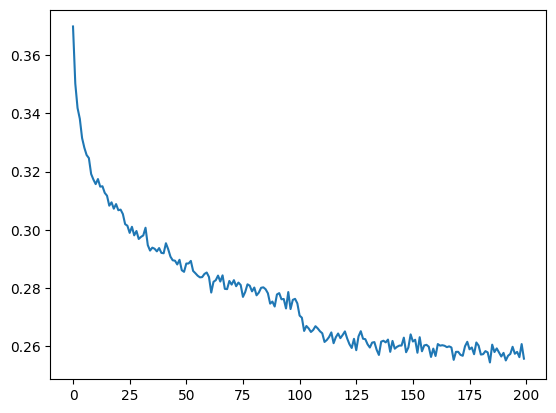

In [7]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [8]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_dev, y_dev),
    'test': (X_test, y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7693147659301758
val 1.9940834045410156
